In [4]:
# Notebook configuration
HNSWLIB_RESULTS_DIR = "./results"
GT_DIR = "/mnt/nas1/fvs_benchmark_datasets"

In [5]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib widget
import ipywidgets as widgets

In [6]:
# Load CSV
vanilla_csvs = []
gxl_csvs = []

for file in os.listdir(HNSWLIB_RESULTS_DIR):
    print(file)
    if 'vanilla' in file:
        if file.endswith(".csv"):
            fpath = os.path.join(HNSWLIB_RESULTS_DIR, file)
            vanilla_csvs.append(fpath)
    elif 'gxl' in file:
        if file.endswith(".csv"):
            fpath = os.path.join(HNSWLIB_RESULTS_DIR, file)
            gxl_csvs.append(fpath)

if len(vanilla_csvs)==0:
    raise Exception("No CSVs found in vanilla!")
print("found %d CSV files for vanilla" % len(vanilla_csvs))
if len(gxl_csvs)==0:
    raise Exception("No CSVs found in gxl!")
print("found %d CSV files for gxl" % len(gxl_csvs))

gxl_load_deep1B_1m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_20m_ef_64_M_32_gxl_512.csv
vanilla_deep-100M_64_32_512.csv
vis
gxl_load_deep1B_50m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_100m_ef_64_M_32_gxl_512.csv
gxl_load_deep1B_250m_ef_64_M_32_gxl_512.csv
old
vanilla_deep-10M_64_32_512.csv
vanilla_deep-1M_64_32_512.csv
vanilla_deep-20M_64_32_512.csv
gxl_load_deep1B_10m_ef_64_M_32_gxl_512.csv
vanilla_deep-250M_64_32_512.csv
vanilla_deep-50M_64_32_512.csv
found 6 CSV files for vanilla
found 6 CSV files for gxl


In [9]:
# Load to df
vanilla_dfs = []
gxl_dfs = []

for csv in vanilla_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    vanilla_dfs.append(df)

for csv in gxl_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    gxl_dfs.append(df)

# concat into one master
print("Concatenating into one master dataframe...")
vanilla_df = pd.concat( vanilla_dfs )
gxl_df = pd.concat( gxl_dfs )
print("There are %d rows" % vanilla_df.shape[0])
print("There are %d rows" % gxl_df.shape[0])
vanilla_df.head(10)

Concatenating into one master dataframe...
There are 24006 rows
There are 24006 rows


,Unnamed: 0,operation,start_time,end_time,walltime,units,dataset,numrecs,ef_construction,M,ef_search,labels,distances
0,0,build,2023-11-19 23:14:30.951868,2023-11-19 23:34:47.954797,1217.002929,seconds,deep-100M,100000000,64,32,-1,-1,-1
1,1,search,2023-11-19 23:34:47.954884,2023-11-19 23:34:47.955397,0.513000,milliseconds,deep-100M,100000000,-1,-1,64,[[81481139 94128829 19024690 95226405 13581574...,[[0.25876737 0.27509606 0.27947974 0.28358442 ...
2,2,search,2023-11-19 23:34:47.955411,2023-11-19 23:34:47.956043,0.632000,milliseconds,deep-100M,100000000,-1,-1,64,[[28865574 30178810 50503969 77549732 5376471...,[[0.20668411 0.2276389 0.22778314 0.22826314 ...
3,3,search,2023-11-19 23:34:47.956055,2023-11-19 23:34:47.956497,0.442000,milliseconds,deep-100M,100000000,-1,-1,64,[[44979692 42923332 51302455 28323107 95192463...,[[0.11710042 0.13195956 0.136747 0.13991565 ...
4,4,search,2023-11-19 23:34:47.956508,2023-11-19 23:34:47.956970,0.462000,milliseconds,deep-100M,100000000,-1,-1,64,[[82914671 94471465 75592195 1295275 68028299...,[[0.14845824 0.1687792 0.17628407 0.1832043 ...
5,5,search,2023-11-19 23:34:47.956983,2023-11-19 23:34:47.957503,0.520000,milliseconds,deep-100M,100000000,-1,-1,64,[[56535548 30108946 42958234 93417951 6790188...,[[0.08438694 0.08880103 0.09369987 0.09412944 ...
6,6,search,2023-11-19 23:34:47.957512,2023-11-19 23:34:47.957907,0.395000,milliseconds,deep-100M,100000000,-1,-1,64,[[75049373 32890853 24270805 30862593 59481716...,[[0.11868262 0.11871922 0.11888528 0.11981428 ...
7,7,search,2023-11-19 23:34:47.957915,2023-11-19 23:34:47.958163,0.248000,milliseconds,deep-100M,100000000,-1,-1,64,[[37686298 74724084 87529232 25148085 16526549...,[[0.02497619 0.03451735 0.03458488 0.03669041 ...
8,8,search,2023-11-19 23:34:47.958170,2023-11-19 23:34:47.958708,0.538000,milliseconds,deep-100M,100000000,-1,-1,64,[[ 7018273 17037971 93017933 76301604 7759835...,[[0.12547255 0.12803799 0.132258 0.13353574 ...
9,9,search,2023-11-19 23:34:47.958720,2023-11-19 23:34:47.959131,0.411000,milliseconds,deep-100M,100000000,-1,-1,64,[[68805098 86212383 31415266 30527318 62930495...,[[0.21122271 0.21956217 0.22419703 0.23685259 ...


In [44]:
gxl_df.head()

,Unnamed: 0,operation,start_time,end_time,walltime,units,dataset,numrecs,ef_construction,M,ef_search,labels,distances
0,0,load,2023-11-19 23:30:55.957734,2023-11-19 23:31:04.479240,8.521506,seconds,deep1B,1000000,64,32,-1,-1,-1
1,1,search,2023-11-19 23:31:04.479347,2023-11-19 23:31:04.481946,2.599000,milliseconds,deep1B,1000000,-1,-1,64,[[300406 545689 109488 223620 792497 759199 48...,[[0.31446922 0.32851034 0.33148217 0.36020595 ...
2,2,search,2023-11-19 23:31:04.481987,2023-11-19 23:31:04.483236,1.249000,milliseconds,deep1B,1000000,-1,-1,64,[[666491 336278 425347 607729 181049 928613 82...,[[0.26592153 0.27344263 0.27681613 0.27965438 ...
3,3,search,2023-11-19 23:31:04.483260,2023-11-19 23:31:04.484120,0.860000,milliseconds,deep1B,1000000,-1,-1,64,[[728484 687286 395448 356564 87115 970904 35...,[[0.16732323 0.18375957 0.18661839 0.18771064 ...
4,4,search,2023-11-19 23:31:04.484135,2023-11-19 23:31:04.484991,0.856000,milliseconds,deep1B,1000000,-1,-1,64,[[506719 731341 552728 397389 544872 26049 74...,[[0.23159689 0.23219824 0.24066609 0.25248218 ...


## GT

In [34]:
num_records = '10M'
gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)

In [36]:
gt = np.load(gt_file, allow_pickle=True)
type(gt)


(1000, 100)

In [7]:
def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    else: raise Exception("Unsupported size" + str(numrecs))
    
def compute_recall(a, b):
    '''Computes the recall metric on query results.'''

    nq, rank = a.shape
    intersect = [ np.intersect1d(a[i, :rank], b[i, :rank]).size for i in range(nq) ]
    ninter = sum( intersect )
    return ninter / a.size, intersect

In [45]:
dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []

for numrecs in vanilla_df['numrecs'].unique():
    ef_unique = vanilla_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        recall_lst = []
        latency_lst = []
        
        df = vanilla_df[(vanilla_df['ef_search']== ef_search) & (vanilla_df['numrecs'] == numrecs)]
        if len(df) != 1000:
            raise Exception("not equal to 1000")

        for j in range(len(df)):
            row = df.iloc[j]
            lbl = row.labels
            latency = row.walltime

            # transform lbl
            lbl_trunc = lbl[2:-2]
            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
            lbl_reshape = lbl_converted.reshape(1, 10)
            gt_reshape = gt[j][:10].reshape(1, 10)

            # compute recall
            recall, cnt = compute_recall(gt_reshape, lbl_reshape)
            recall_lst.append(recall)
            latency_lst.append(latency)

           
        recall10_mean.append(np.mean(recall_lst))
        latency_mean.append(np.mean(latency_lst))
        numrecs_lst.append(num_records)
        ef_search_lst.append(ef_search)
        print(num_records, ef_search, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))
dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
vanilla_result_df = pd.DataFrame(dic)
        


100M 64 1000 0.8562000000000001 0.448322
100M 128 1000 0.916 0.798294
100M 256 1000 0.9549000000000001 1.545902
100M 512 1000 0.9766000000000001 3.1349260000000005
10M 64 1000 0.9183 0.324005
10M 128 1000 0.9584000000000001 0.616213
10M 256 1000 0.9797 1.227759
10M 512 1000 0.9895 2.365652
1M 64 1000 0.9481000000000002 0.21975199999999998
1M 128 1000 0.9771000000000002 0.37929199999999996
1M 256 1000 0.9909 0.675563
1M 512 1000 0.9965 1.3459139999999998
20M 64 1000 0.8994000000000001 0.35451800000000006
20M 128 1000 0.9481 0.607238
20M 256 1000 0.9747 1.1084960000000001
20M 512 1000 0.9867 2.132679
250M 64 1000 0.8335999999999999 0.436799
250M 128 1000 0.8999000000000001 0.742761
250M 256 1000 0.9462 1.3735189999999997
250M 512 1000 0.9714 2.5794210000000004
50M 64 1000 0.8647 0.392462
50M 128 1000 0.9266 0.695628
50M 256 1000 0.962 1.259737
50M 512 1000 0.9795 2.2985170000000004


In [46]:
dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []

for numrecs in gxl_df['numrecs'].unique():
    ef_unique = gxl_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        recall_lst = []
        latency_lst = []
        
        df = gxl_df[(gxl_df['ef_search']== ef_search) & (gxl_df['numrecs'] == numrecs)]
        if len(df) != 1000:
            raise Exception("not equal to 1000")

        for j in range(len(df)):
            row = df.iloc[j]
            lbl = row.labels
            latency = row.walltime

            # transform lbl
            lbl_trunc = lbl[2:-2]
            lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
            lbl_reshape = lbl_converted.reshape(1, 10)
            gt_reshape = gt[j][:10].reshape(1, 10)

            # compute recall
            recall, cnt = compute_recall(gt_reshape, lbl_reshape)
            recall_lst.append(recall)
            latency_lst.append(latency)

           
        recall10_mean.append(np.mean(recall_lst))
        latency_mean.append(np.mean(latency_lst))
        numrecs_lst.append(num_records)
        ef_search_lst.append(ef_search)
        print(num_records, ef_search, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))
dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
gxl_result_df = pd.DataFrame(dic)
        


1M 64 1000 0.9748000000000001 0.839828
1M 128 1000 0.9909000000000001 1.426993
1M 256 1000 0.9974000000000001 2.564922
1M 512 1000 0.9990999999999999 4.516747
20M 64 1000 0.9378 0.486562
20M 128 1000 0.9713 0.8252430000000001
20M 256 1000 0.988 1.508037
20M 512 1000 0.9946 2.7918819999999998
50M 64 1000 0.917 0.5652539999999999
50M 128 1000 0.9596 0.927114
50M 256 1000 0.982 1.705781
50M 512 1000 0.9933 3.1631380000000004
100M 64 1000 0.9016000000000001 1.382641
100M 128 1000 0.9495 2.0738250000000003
100M 256 1000 0.9752000000000001 4.792348
100M 512 1000 0.9885 12.528867
250M 64 1000 0.8736 0.82149
250M 128 1000 0.9321 1.044417
250M 256 1000 0.9668 1.888232
250M 512 1000 0.9847 3.5594189999999997
10M 64 1000 0.9496 0.439169
10M 128 1000 0.9791000000000001 0.7439549999999999
10M 256 1000 0.9913000000000001 1.350287
10M 512 1000 0.9953999999999998 2.486701


In [47]:
gxl_result_df

,numrecs,ef_search,recall@10,latency
0,1M,64,0.9748,0.839828
1,1M,128,0.9909,1.426993
2,1M,256,0.9974,2.564922
3,1M,512,0.9991,4.516747
4,20M,64,0.9378,0.486562
5,20M,128,0.9713,0.825243
6,20M,256,0.9880,1.508037
7,20M,512,0.9946,2.791882
8,50M,64,0.9170,0.565254
9,50M,128,0.9596,0.927114


  numrecs  ef_search  recall@10   latency
4     10M         64     0.9183  0.324005
5     10M        128     0.9584  0.616213
6     10M        256     0.9797  1.227759
7     10M        512     0.9895  2.365652
   numrecs  ef_search  recall@10   latency
20     10M         64     0.9496  0.439169
21     10M        128     0.9791  0.743955
22     10M        256     0.9913  1.350287
23     10M        512     0.9954  2.486701
[0.324005, 0.616213, 1.227759, 2.365652] [0.9183, 0.9584000000000001, 0.9797, 0.9895]
[0.439169, 0.7439549999999999, 1.350287, 2.486701] [0.9496, 0.9791000000000001, 0.9913000000000001, 0.9953999999999998]


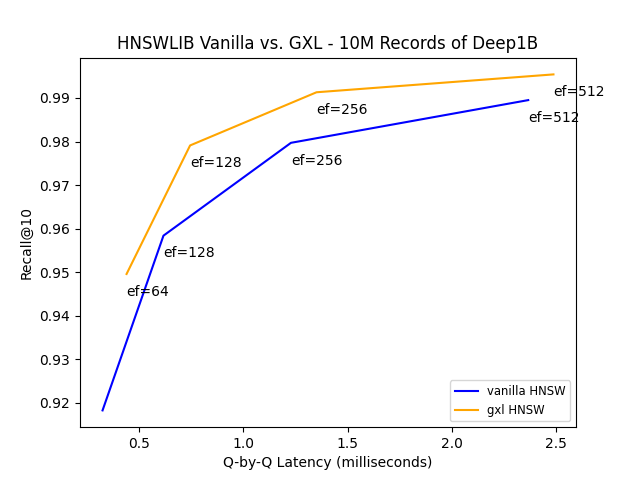

In [48]:
# 10M

df_vanilla_10M = vanilla_result_df[ vanilla_result_df['numrecs']=='10M']
print(df_vanilla_10M )
df_gxl_10M = gxl_result_df[ gxl_result_df['numrecs']=='10M']
print(df_gxl_10M )

# extract the lines for plotting
paretto_vanilla_parameters = list(df_vanilla_10M ['ef_search'])
paretto_vanilla_search = list(df_vanilla_10M ['latency'])
paretto_vanilla_recall = list(df_vanilla_10M ['recall@10'])
print(paretto_vanilla_search, paretto_vanilla_recall)

paretto_gxl_parameters = list(df_gxl_10M ['ef_search'])
paretto_gxl_search = list(df_gxl_10M ['latency'])
paretto_gxl_recall = list(df_gxl_10M ['recall@10'])
print(paretto_gxl_search, paretto_gxl_recall)

# plot
fig, ax = plt.subplots()
ax.plot(paretto_vanilla_search, paretto_vanilla_recall, color='blue', label='vanilla HNSW')
ax.plot(paretto_gxl_search, paretto_gxl_recall, color='orange', label='gxl HNSW')

# annotate hnsw
for i, bits in enumerate(paretto_vanilla_parameters):
    ax.annotate("ef=%d"%bits, 
            xy=(paretto_vanilla_search[i],paretto_vanilla_recall[i]-0.005 ), 
            xytext=(0.0,0.0),
            textcoords="offset points"
            )
for i, bits in enumerate(paretto_gxl_parameters):
    ax.annotate("ef=%d"%bits, 
            xy=(paretto_gxl_search[i],paretto_gxl_recall[i]-0.005 ), 
            xytext=(0.0,0.0),
            textcoords="offset points"
            )

ax.set_xlabel("Q-by-Q Latency (milliseconds)")
ax.set_ylabel("Recall@10")
plt.title("HNSWLIB Vanilla vs. GXL - 10M Records of Deep1B")
ax.legend(loc='lower right', fontsize='small')

fig.savefig("results/vis/vanilla_gxl_paretto_10M.png")

In [ ]:
# p90/95/99 latency, show not just mean, capture in a csv
# error bar along y axis, range, interval, stats interval, boxplots intervals, coretile analysis for recall

In [55]:
def plot_paretto(num_records):

    df_vanilla = vanilla_result_df[ vanilla_result_df['numrecs'] == num_records]
    print(df_vanilla )
    df_gxl = gxl_result_df[ gxl_result_df['numrecs'] == num_records]
    print(df_gxl )

    # extract the lines for plotting
    paretto_vanilla_parameters = list(df_vanilla ['ef_search'])
    paretto_vanilla_search = list(df_vanilla ['latency'])
    paretto_vanilla_recall = list(df_vanilla ['recall@10'])
    print(paretto_vanilla_search, paretto_vanilla_recall)

    paretto_gxl_parameters = list(df_gxl ['ef_search'])
    paretto_gxl_search = list(df_gxl ['latency'])
    paretto_gxl_recall = list(df_gxl ['recall@10'])
    print(paretto_gxl_search, paretto_gxl_recall)

    # plot
    fig, ax = plt.subplots()
    ax.plot(paretto_vanilla_search, paretto_vanilla_recall, color='blue', label='vanilla HNSW')
    ax.plot(paretto_gxl_search, paretto_gxl_recall, color='orange', label='gxl HNSW')

    # annotate hnsw
    for i, bits in enumerate(paretto_vanilla_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_vanilla_search[i],paretto_vanilla_recall[i]-0.005 ), 
                xytext=(0.0,0.0),
                textcoords="offset points"
                )
    for i, bits in enumerate(paretto_gxl_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_gxl_search[i],paretto_gxl_recall[i]-0.005 ), 
                xytext=(0.0,0.0),
                textcoords="offset points"
                )

    ax.set_xlabel("Q-by-Q Latency (milliseconds)")
    ax.set_ylabel("Recall@10")
    title = f"HNSWLIB Vanilla vs. GXL - {num_records} Records of Deep1B"
    plt.title(title)
    ax.legend(loc='lower right', fontsize='small')

    save_path = f'results/vis/vanilla_gxl_paretto{num_records}.png'

    fig.savefig(save_path)

    return "done"

  numrecs  ef_search  recall@10   latency
0    100M         64     0.8562  0.448322
1    100M        128     0.9160  0.798294
2    100M        256     0.9549  1.545902
3    100M        512     0.9766  3.134926
   numrecs  ef_search  recall@10    latency
12    100M         64     0.9016   1.382641
13    100M        128     0.9495   2.073825
14    100M        256     0.9752   4.792348
15    100M        512     0.9885  12.528867
[0.448322, 0.798294, 1.545902, 3.1349260000000005] [0.8562000000000001, 0.916, 0.9549000000000001, 0.9766000000000001]
[1.382641, 2.0738250000000003, 4.792348, 12.528867] [0.9016000000000001, 0.9495, 0.9752000000000001, 0.9885]
  numrecs  ef_search  recall@10   latency
4     10M         64     0.9183  0.324005
5     10M        128     0.9584  0.616213
6     10M        256     0.9797  1.227759
7     10M        512     0.9895  2.365652
   numrecs  ef_search  recall@10   latency
20     10M         64     0.9496  0.439169
21     10M        128     0.9791  0.743955
22 

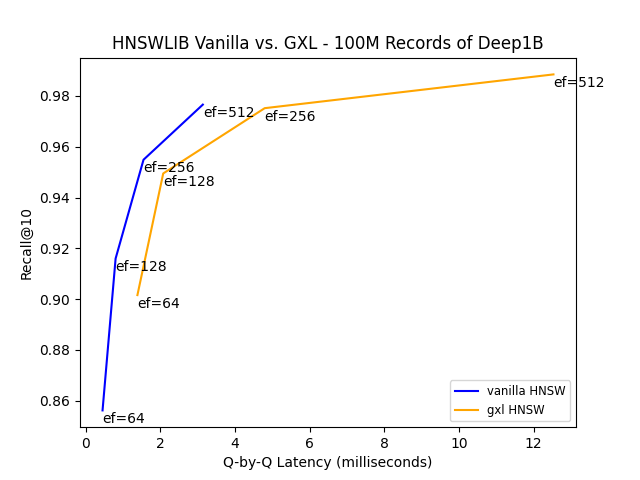

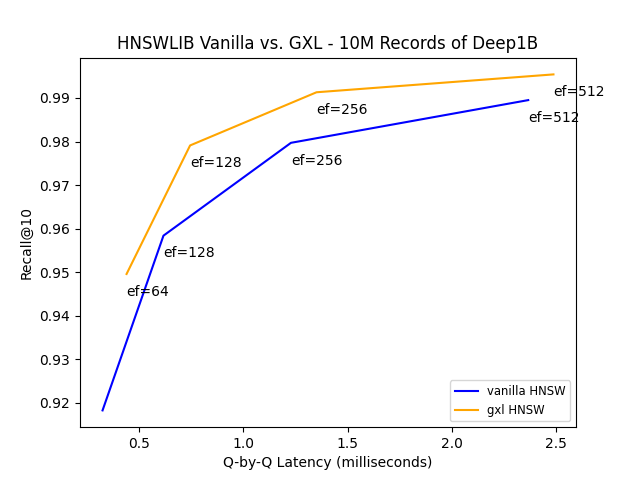

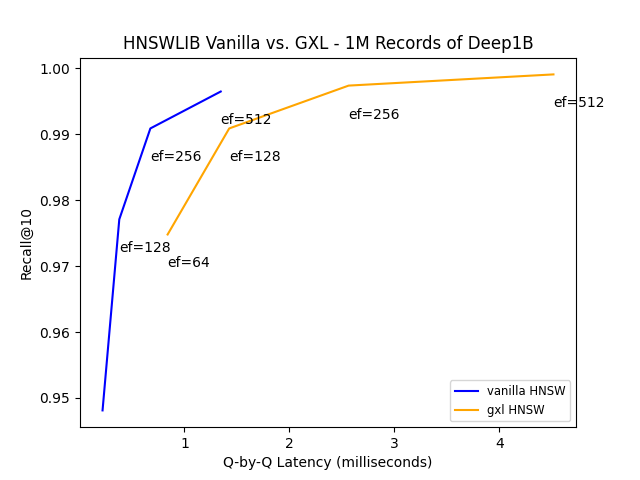

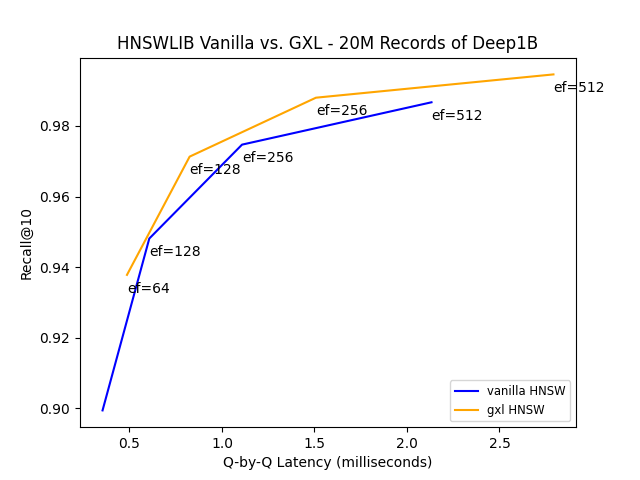

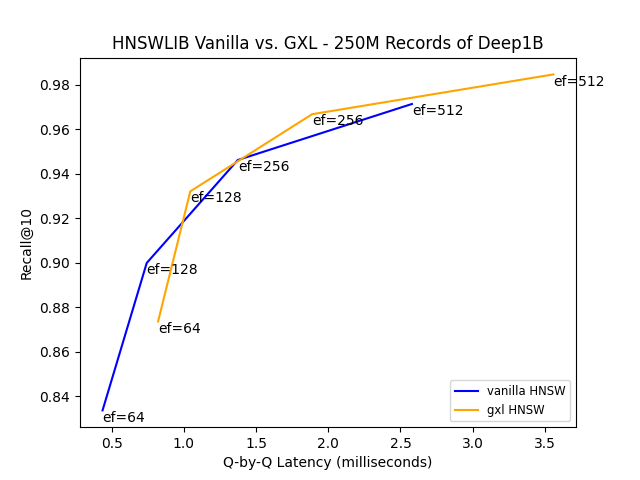

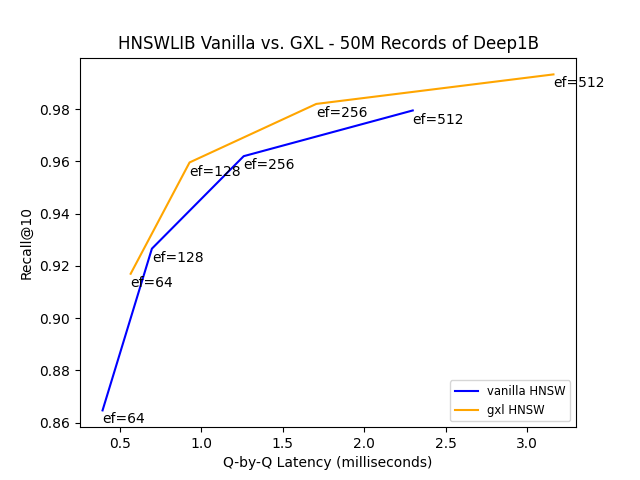

In [56]:
for i in vanilla_result_df.numrecs.unique():
    plot_paretto(i)

vanilla search time [1000000, 10000000, 20000000, 50000000, 100000000, 250000000] [0.65513025, 1.1334072499999999, 1.0507327499999999, 1.161586, 1.481861, 1.283125]


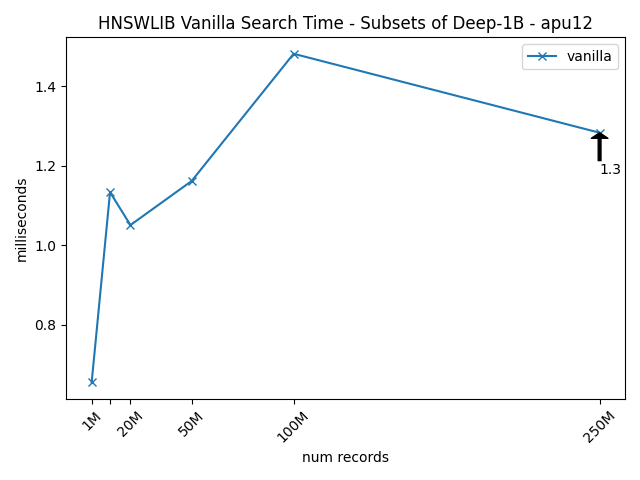

In [57]:
# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_search_walltime = \
    vanilla_df[vanilla_df['operation'] == 'search'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_walltime.index:
    x = idx
    xs.append(x)
    #y = avg_search_wall_import_time[idx]/(1000*60.0*60.0) # milliseconds
    y = avg_search_walltime[idx] # milliseconds
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('milliseconds')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB Vanilla Search Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/vanilla_hnswlib_walltime.png")

gxl search time [10000000, 20000000, 50000000] [9.949027777777779e-05, 0.0001159675, 0.00013330666666666667]


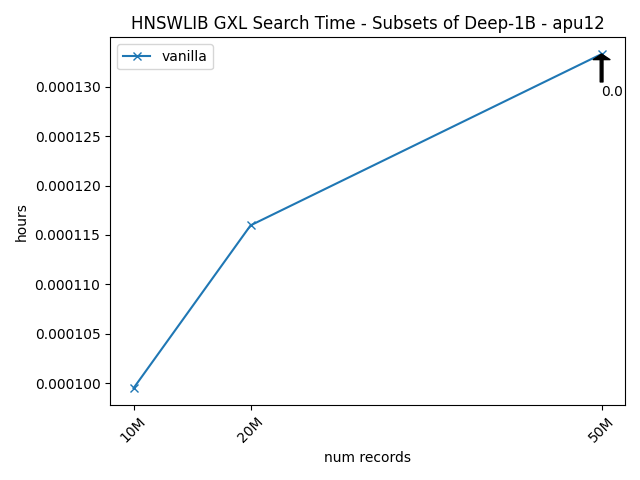

In [22]:
# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_search_wall_time = \
    gxl_df[gxl_df['operation'] == 'search'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_wall_time.index:
    x = idx
    xs.append(x)
    y = avg_search_wall_time[idx]/(1000*60.0*60.0)
    ys.append(y)
print("gxl search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
#ax.set_xticklabels(['10M', '20M', '50M', '100M', '250M', '500M'], rotation = 45)
ax.set_xticklabels(['10M', '20M', '50M', '100M', '250M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB GXL Search Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/gxl_hnswlib_search_walltime.png")

vanilla search time [1000000, 10000000, 20000000, 50000000, 100000000, 250000000, 500000000] [0.002015384166666667, 0.027022098055555555, 0.058055555555555555, 0.1625, 0.3413888888888889, 0.92, 1.9647222222222223]


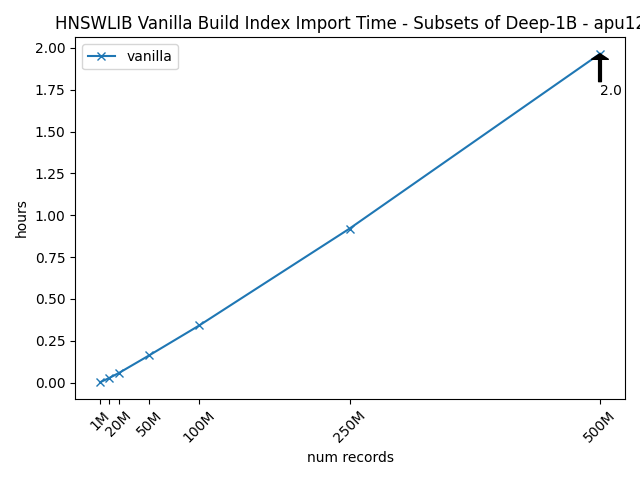

In [23]:
# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
avg_wall_import_time = \
    vanilla_df[vanilla_df['operation'] == 'build'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_wall_import_time.index:
    x = idx
    xs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '', '20M', '50M', '100M', '250M', '500M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB Vanilla Build Index Import Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/vanilla_hnswlib_wall_import_time_build.png")

In [ ]:
df = df.loc[(df['col2'] == 1) | (df['col2'] == 2)]

In [34]:
df = vanilla_df.loc[(vanilla_df['numrecs'] == 1000000) | (vanilla_df['numrecs'] == 10000000)]

avg_search_walltime = \
    df[df['operation'] == 'search'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

avg_search_walltime

numrecs
1000000      93.422222
10000000    132.894891
Name: walltime, dtype: float64

In [59]:
df = vanilla_df.loc[(vanilla_df['numrecs'] == 1000000)]

avg_search_walltime = \
    df[df['operation'] == 'search'].groupby( [ 'numrecs', 'ef_search' ] )

df.groupby(['ef_search'])['walltime'].mean()

ef_search
-1      7.275183
 64     0.219752
 128    0.379292
 256    0.675563
 512    1.345914
Name: walltime, dtype: float64

<Axes: xlabel='numrecs'>

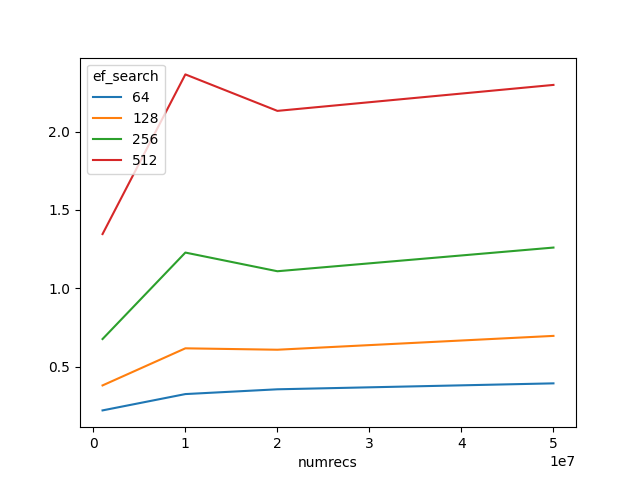

In [25]:
df = vanilla_df.loc[(vanilla_df['numrecs'] == 1000000) | (vanilla_df['numrecs'] == 10000000) | (vanilla_df['numrecs'] == 20000000) | (vanilla_df['numrecs'] == 50000000)]

avg_search_walltime = \
    df[df['operation'] == 'search'].groupby( [ 'numrecs', 'ef_search' ] ) ['walltime'].mean()

avg_search_walltime.unstack().plot()
#plt.xticks([0, 1, 2, 3], ['1M', '10M', '20M', '50M'], rotation = 45)

In [11]:
# get the plot points for import time
xs = []
ys = []
for idx in avg_search_walltime.index:
    x = idx
    xs.append(x)
    y = avg_search_walltime[idx] # milliseconds
    ys.append(y)
print("vanilla search time", xs, ys)

vanilla search time [(1000000, 64), (1000000, 128), (1000000, 256), (1000000, 512), (10000000, 64), (10000000, 128), (10000000, 256), (10000000, 512), (20000000, 64), (20000000, 128), (20000000, 256), (20000000, 512), (50000000, 64), (50000000, 128), (50000000, 256), (50000000, 512)] [0.21975199999999998, 0.37929199999999996, 0.675563, 1.345914, 0.324005, 0.616213, 1.227759, 2.365652, 0.354518, 0.607238, 1.1084960000000001, 2.132679, 0.392462, 0.695628, 1.259737, 2.298517]


vanilla search time [1000000, 10000000, 20000000, 50000000] [7.275183, 95.737654, 206.931259, 576.152025]


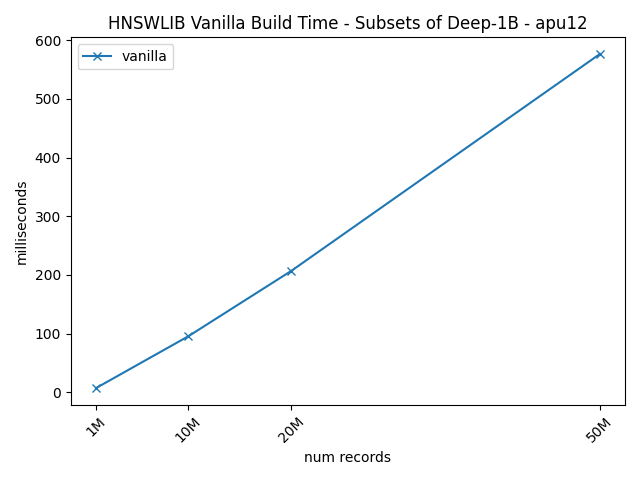

In [26]:
# Plot walltime

# compute average search walltime via groupby
df = vanilla_df.loc[(vanilla_df['numrecs'] == 1000000) | (vanilla_df['numrecs'] == 10000000) | (vanilla_df['numrecs'] == 20000000) | (vanilla_df['numrecs'] == 50000000)]

avg_search_walltime = \
    df[df['operation'] == 'build'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_walltime.index:
    x = idx
    xs.append(x)
    y = avg_search_walltime[idx] # milliseconds
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('milliseconds')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '10M', '20M', '50M'], rotation = 45)

ax.set_title("HNSWLIB Vanilla Build Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/vanilla_hnswlib_build_walltime.png")

vanilla search time [10000000, 20000000, 50000000] [1.255028, 1.4029310000000002, 1.59032175]


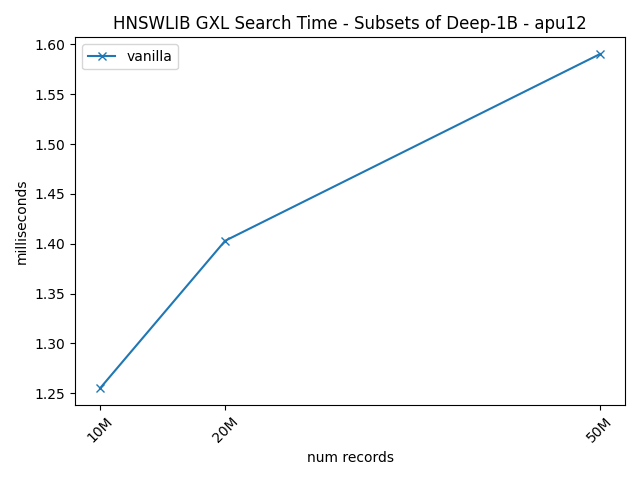

In [27]:
# Plot walltime

# compute average search walltime via groupby
df = gxl_df.loc[(gxl_df['numrecs'] == 10000000) | (gxl_df['numrecs'] == 20000000) | (gxl_df['numrecs'] == 50000000)]

avg_search_walltime = \
    df[df['operation'] == 'search'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_walltime.index:
    x = idx
    xs.append(x)
    y = avg_search_walltime[idx] # milliseconds
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('milliseconds')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['10M', '20M', '50M'], rotation = 45)

ax.set_title("HNSWLIB GXL Search Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/gxl_hnswlib_walltime.png")

vanilla search time [1000000, 10000000] [7.275183, 95.737654]


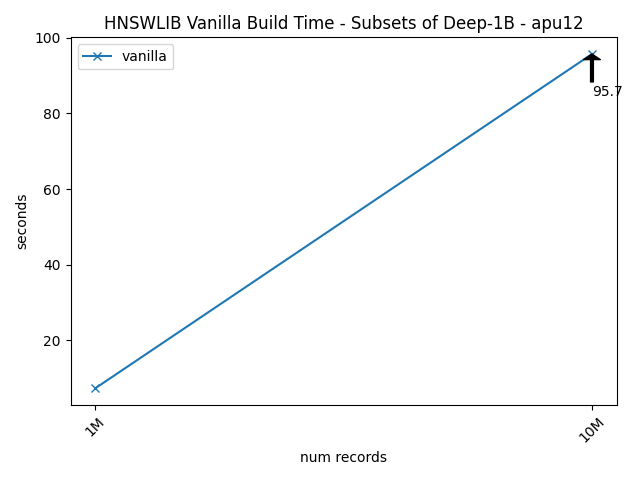

In [8]:
# plot one line of latest, matching label with the og notebook 
# Plot import/train times

# compute average wall import time via groupby
df = vanilla_df.loc[(vanilla_df['numrecs'] == 1000000) | (vanilla_df['numrecs'] == 10000000)]

avg_search_walltime = \
    df[df['operation'] == 'build'].groupby( [ 'numrecs' ] ) ['walltime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_search_walltime.index:
    x = idx
    xs.append(x)
    #y = avg_search_wall_import_time[idx]/(1000*60.0*60.0) # milliseconds
    y = avg_search_walltime[idx] # seconds
    ys.append(y)
print("vanilla search time", xs, ys)

# plot the lines and label the plot
fig, ax = plt.subplots()

#
# only show the wall time lines
#
ax.plot(xs, ys, marker='x', label='vanilla')
ax.set_ylabel('seconds')
ax.set_xlabel('num records')
ax.set_xticks(xs)

# don't show all xticks near the start since they bunch up
ax.set_xticklabels(['1M', '10M'], rotation = 45)

#
# annotate last data point in lines of interest
latest_hours = "%.1f" % ys[-1]
ax.annotate(latest_hours, xy=(xs[-1],ys[-1]), xytext=(0.0,-30),
            textcoords="offset points",
            arrowprops=dict(facecolor='black',width=2,headlength=4),
            )

ax.set_title("HNSWLIB Vanilla Build Time - Subsets of Deep-1B - apu12")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/vis/vanilla_hnswlib_build_walltime.png")

# Import GXL Index Build Time

In [ ]:
gxl_path = "/mnt/nas1/GXL/deep1B/v2.0_with250Mfix"